In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import numpy as np
from pyspark import SparkConf
from wordcloud import WordCloud, STOPWORDS

In [2]:
conf = (
    SparkConf()
      .setMaster("local[*]")                
      .setAppName("EDA Pyspark")
      .set("spark.driver.host","127.0.0.1")
      .set("spark.driver.bindAddress","0.0.0.0")
)

In [3]:
spark=SparkSession.builder.config(conf=conf).getOrCreate()

25/04/26 17:16:52 WARN Utils: Your hostname, Amey resolves to a loopback address: 127.0.0.1; using 192.168.1.153 instead (on interface en0)
25/04/26 17:16:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/26 17:16:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

## Re-perform exploratory data analysis (EDA) using PySpark

In [5]:
job_skills=spark.read.csv("hdfs://localhost:9000/user/hadoop/job_data/job_skills.csv",header=True,inferSchema=True)

In [6]:
job_summary=spark.read.csv("hdfs://localhost:9000/user/hadoop/job_data/job_summary.csv",header=True,inferSchema=True,
                           multiLine=True,quote='"',escape='"',ignoreLeadingWhiteSpace=True,ignoreTrailingWhiteSpace=True)

In [7]:
job_postings = spark.read.csv("hdfs://localhost:9000/user/hadoop/job_data/linkedin_job_postings.csv",header=True,inferSchema=True,
    multiLine=True,quote='"',escape='"',ignoreLeadingWhiteSpace=True,ignoreTrailingWhiteSpace=True)

In [8]:
print("Job Skills")
job_skills.printSchema()

Job Skills
root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)



In [9]:
print("Count:", job_skills.count())

Count: 1296381


In [10]:
print("\nJob Summary")
job_summary.printSchema()


Job Summary
root
 |-- job_link: string (nullable = true)
 |-- job_summary: string (nullable = true)



In [11]:
print("Count:", job_summary.count())

Count: 1297332


In [12]:
print("\nJob Postings")
job_postings.printSchema()


Job Postings
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)



In [13]:
print("Count:", job_postings.count())

Count: 1348454


In [14]:
def null_summary(df,n):
    print(f"\nNull Counts for: {n}")
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

In [15]:
null_summary(job_skills,"job skills")


Null Counts for: job skills


+--------+----------+
|job_link|job_skills|
+--------+----------+
|       0|      2007|
+--------+----------+



In [16]:
null_summary(job_summary,"job summary")


Null Counts for: job summary


+--------+-----------+
|job_link|job_summary|
+--------+-----------+
|       0|          0|
+--------+-----------+



In [17]:
null_summary(job_postings,"job postings")


Null Counts for: job postings


+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|job_link|last_processed_time|got_summary|got_ner|is_being_worked|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|       0|                  0|          0|      0|              0|        0|     11|          19|         0|          0|             0|              0|        0|       0|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+



In [18]:
print("\nSummary Stats Job Postings")
job_postings.describe().show()

25/04/26 17:18:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.



Summary Stats Job Postings


+-------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+-----------+--------------+----------------+----------+--------+
|summary|            job_link|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|search_city|search_country| search_position| job_level|job_type|
+-------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+-----------+--------------+----------------+----------+--------+
|  count|             1348454|    1348454|1348454|        1348454|             1348454|             1348443|             1348435|    1348454|       1348454|         1348454|   1348454| 1348454|
|   mean|                NULL|       NULL|   NULL|           NULL|                NULL|   882.4166666666666|                NULL|       NULL|          NULL|            NULL|      NULL|    NULL|
| stddev|                NULL|

In [19]:
print("\nSummary Stats Job Summary")
job_summary.describe().show()


Summary Stats Job Summary


+-------+--------------------+--------------------+
|summary|            job_link|         job_summary|
+-------+--------------------+--------------------+
|  count|             1297332|             1297332|
|   mean|                NULL|                NULL|
| stddev|                NULL|                NULL|
|    min|https://ae.linked...|! CURRENTLY SEEKI...|
|    max|https://za.linked...|🪠 We invite full...|
+-------+--------------------+--------------------+



In [20]:
top_jobs=job_postings.groupBy("job_title").count().orderBy(F.desc("count")).limit(20).toPandas()

In [21]:
top_jobs.set_index("job_title", inplace=True)

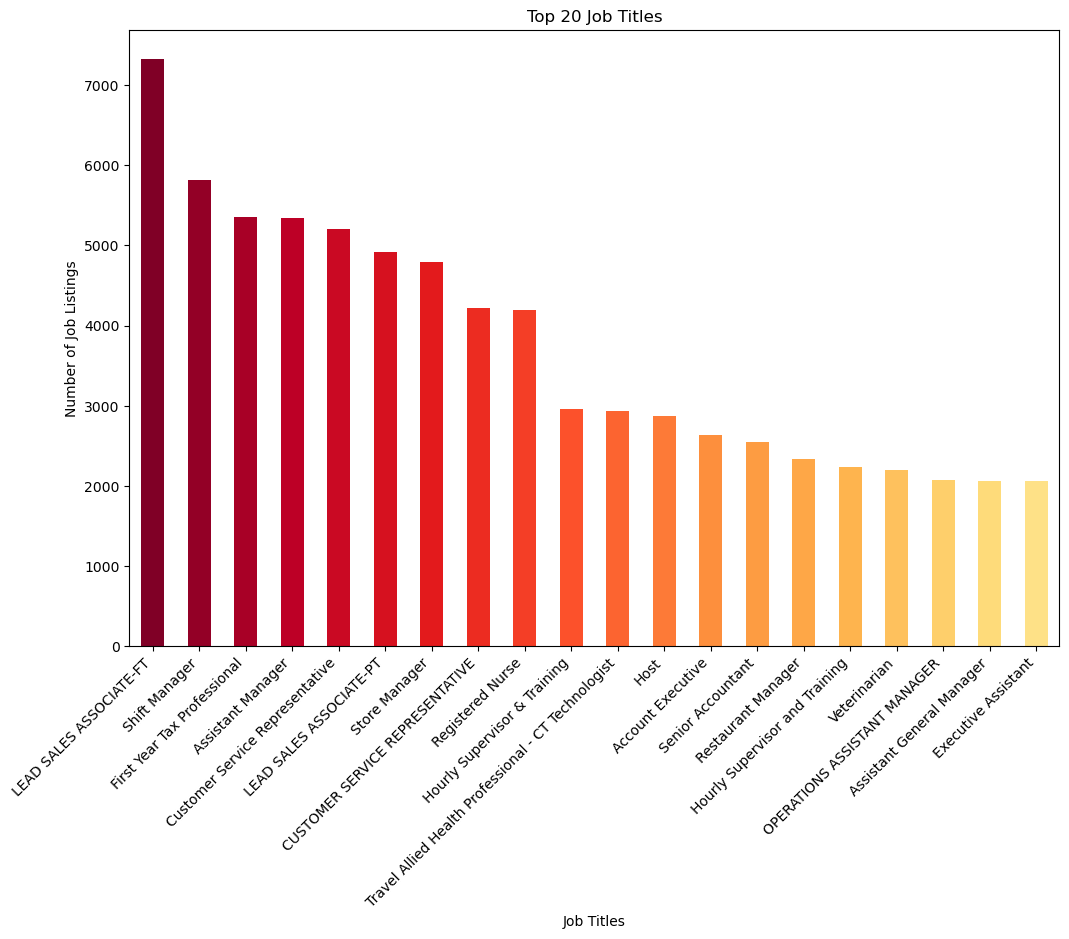

In [22]:
colors = cm.YlOrRd(np.linspace(1, 0.2, len(top_jobs)))

plt.figure(figsize=(12, 8))
top_jobs["count"].plot(kind="bar", color=colors)
plt.title('Top 20 Job Titles')
plt.xlabel('Job Titles')

plt.ylabel('Number of Job Listings')
plt.xticks(rotation=45,ha='right')

plt.show()

In [23]:
top_companies=job_postings.groupBy("company").count().orderBy(F.desc("count")).limit(15).toPandas()

In [24]:
top_companies.set_index("company",inplace=True)
top_companies=top_companies["count"].sort_values()

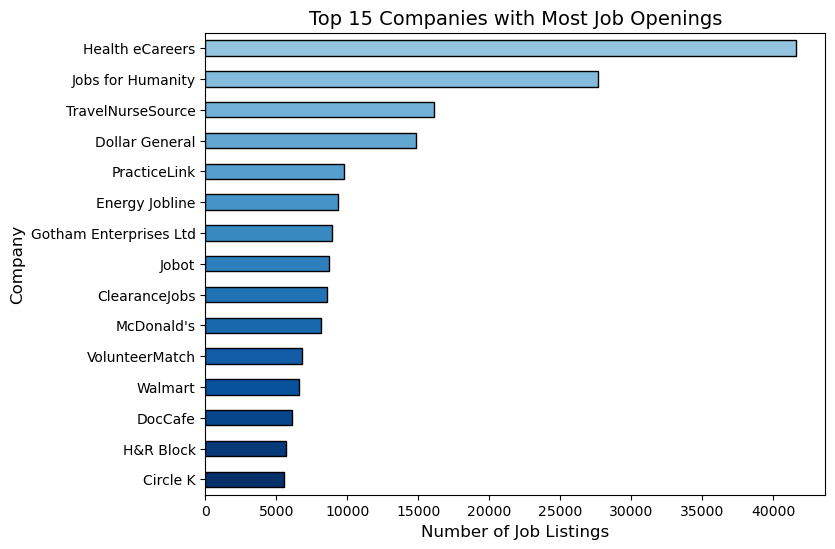

In [25]:
colors = plt.cm.Blues(np.linspace(1,0.4,len(top_companies)))

ax = top_companies.plot(kind="barh",color=colors, edgecolor='black',figsize=(8,6))

ax.set_title('Top 15 Companies with Most Job Openings',fontsize=14)
ax.set_xlabel('Number of Job Listings',fontsize=12)

ax.set_ylabel('Company',fontsize=12)
plt.show()

colors=cm.Blues(np.linspace(0.4,1,len(top_companies)))

top_companies.plot(kind='barh',color=colors,edgecolor='black')

plt.title('Top 15 Companies with Most Job Openings',fontsize=14)
plt.xlabel('Number of Job Listings',fontsize=14)
plt.ylabel('Company',fontsize=14)

plt.xticks(rotation=45, ha='right',fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [27]:
job_types=job_postings.groupBy("job_type").count().orderBy(F.desc("count")).toPandas()

In [28]:
job_types.set_index("job_type",inplace=True)
job_types=job_types["count"]

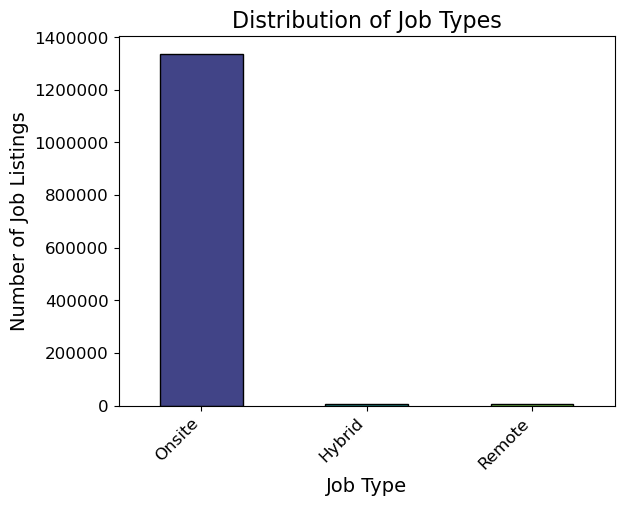

In [29]:
colors = plt.cm.viridis(np.linspace(0.2,0.8,len(job_types)))
job_types.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Distribution of Job Types',fontsize=16)
plt.xlabel('Job Type',fontsize=14)

plt.ylabel('Number of Job Listings',fontsize=14)

plt.xticks(rotation=45,ha='right',fontsize=12)

plt.yticks(fontsize=12)

plt.ticklabel_format(style='plain',axis='y')
plt.show()

In [30]:
job_location_counts = job_postings.groupBy("job_location").count().orderBy(F.desc("count")).limit(10).toPandas()

In [31]:
job_location_counts.set_index("job_location",inplace=True)
job_location_counts=job_location_counts["count"]

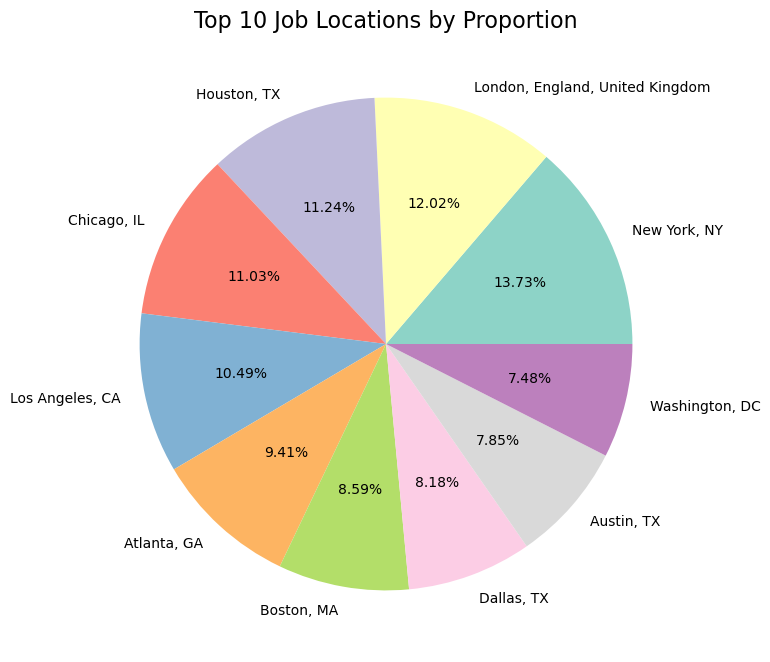

In [32]:
plt.figure(figsize=(8, 8))
plt.pie(job_location_counts,labels=job_location_counts.index,autopct='%1.2f%%',colors=plt.cm.Set3.colors)

plt.title('Top 10 Job Locations by Proportion',fontsize=16)
plt.show()

In [33]:
skills_df=(job_skills.withColumn("skill", F.explode(F.split(F.col("job_skills"), ","))).withColumn("skill", F.trim(F.col("skill"))))

In [34]:
skill_counts_df = (
skills_df.groupBy("skill").count().orderBy(F.desc("count")))

In [35]:
skill_freq={row['skill']:row['count'] for row in skill_counts_df.collect()}

25/04/26 17:19:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 17:19:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 17:19:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 17:19:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 17:19:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 17:19:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 17:19:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 17:19:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 17:19:40 WARN RowBasedKeyValueBatch: Calling spill() on

In [36]:
wordcloud = WordCloud(width=800,height=400,background_color='white',colormap='plasma',max_words=300,   
    stopwords=STOPWORDS,).generate_from_frequencies(skill_freq)

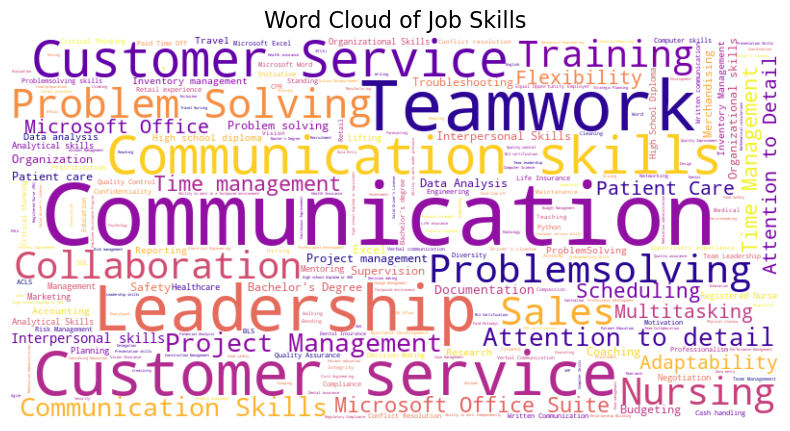

In [37]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')
plt.title('Word Cloud of Job Skills', fontsize=16)

plt.show()

## Use PySpark to clean and process the data that was ingested in Phase I

In [38]:
job_skills_cleaned=job_skills.na.drop(subset=["job_skills"])

In [39]:
job_postings_cleaned=job_postings.na.drop(subset=["company","job_location"])

In [40]:
job_postings_cleaned=job_postings_cleaned.drop("got_summary","got_ner","is_being_worked")

In [41]:
null_summary(job_skills_cleaned,"Cleaned Job Skills")


Null Counts for: Cleaned Job Skills


+--------+----------+
|job_link|job_skills|
+--------+----------+
|       0|         0|
+--------+----------+



In [42]:
null_summary(job_postings_cleaned,"Cleaned Job Posting")


Null Counts for: Cleaned Job Posting


+--------+-------------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|job_link|last_processed_time|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|
+--------+-------------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|       0|                  0|        0|      0|           0|         0|          0|             0|              0|        0|       0|
+--------+-------------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+



In [51]:
print("Job Skills Cleaned")
job_skills_cleaned.printSchema()

Job Skills Cleaned
root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)



In [52]:
print("Job Summary Cleaned")
job_summary.printSchema()

Job Summary Cleaned
root
 |-- job_link: string (nullable = true)
 |-- job_summary: string (nullable = true)



In [53]:
print("Job Postings Cleaned")
job_postings_cleaned.printSchema()

Job Postings Cleaned
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)



In [54]:
merged_df=(job_postings_cleaned.join(job_skills_cleaned,on="job_link",how="left").join(job_summary,on="job_link",how="left"))

In [55]:
print("Whole Dataset:")
merged_df.printSchema()

Whole Dataset:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- job_summary: string (nullable = true)



In [56]:
null_summary(merged_df,"job_skills")


Null Counts for: job_skills


+--------+-------------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+-----------+
|job_link|last_processed_time|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|job_skills|job_summary|
+--------+-------------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+-----------+
|       0|                  0|        0|      0|           0|         0|          0|             0|              0|        0|       0|     54078|      51120|
+--------+-------------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+-----------+



In [57]:
clean=merged_df.na.drop(subset=["job_skills"])

In [58]:
null_summary(clean,"job_skills")


Null Counts for: job_skills


+--------+-------------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+-----------+
|job_link|last_processed_time|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|job_skills|job_summary|
+--------+-------------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+-----------+
|       0|                  0|        0|      0|           0|         0|          0|             0|              0|        0|       0|         0|          0|
+--------+-------------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+-----------+



In [59]:
pandas_df=clean.limit(10).toPandas()

In [60]:
print("\nFirst 10 rows of Whole Cleaned and merged data")
pandas_df.head(10)


First 10 rows of Whole Cleaned and merged data


,job_link,last_processed_time,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,job_summary
0,https://au.linkedin.com/jobs/view/2x-senior-cc...,2024-01-19 04:45:09.215838,2x Senior CCU/ICU RNs - $5000 BONUS - Regional...,Curis Recruitment,"New South Wales, Australia",2024-01-12,New South Wales,Australia,Anesthesiologist,Mid senior,Onsite,"Senior CCU/ICU Registered Nurse, Current AHPRA...",$5000 BONUS AVAILABLE NOW!! Don't miss this fa...
1,https://au.linkedin.com/jobs/view/accident-man...,2024-01-20 18:47:43.734765,Accident Management Specialist,IMOK Accident Replacement Cars,"Sydney, New South Wales, Australia",2024-01-14,New South Wales,Australia,Special Effects Specialist,Mid senior,Onsite,"Motor insurance policies, Auto industry, Motor...",Company Description\nIMOK Accident Replacement...
2,https://au.linkedin.com/jobs/view/account-mana...,2024-01-19 04:45:09.215838,Account Manager,Team Global Express,"Hobart, Tasmania, Australia",2024-01-12,Tasmania,Australia,Account Executive,Mid senior,Hybrid,"Sales, Account Management, Client Relationship...",About Us\nTeam Global Express is an Australian...
3,https://au.linkedin.com/jobs/view/account-mana...,2024-01-19 04:45:09.215838,Account Manager - Rolling Solutions,Sharp & Carter,"Perth, Western Australia, Australia",2024-01-12,Perth,Australia,Account Executive,Mid senior,Onsite,"Account Management, Sales, Customer Relationsh...",About The Role\nThe primary focus of this role...
4,https://au.linkedin.com/jobs/view/account-mana...,2024-01-19 04:45:09.215838,Account Manager - Sales,Impel Management,"Sydney, New South Wales, Australia",2024-01-13,New South Wales,Australia,Field Representative,Mid senior,Onsite,"Account Management, Sales, Strategic Planning,...",Do you have a passion for sales and the financ...
5,https://au.linkedin.com/jobs/view/accountant-i...,2024-01-21 09:31:57.964912,Accountant (Intermediate to Senior),New Point Recruitment,Gold Coast,2024-01-14,Murwillumbah,Australia,Accountant,Mid senior,Onsite,"Accounting, Tax, Auditing, Business Services, ...",Southport CBD. Growing firm with a focus on me...
6,https://au.linkedin.com/jobs/view/accountant-t...,2024-01-19 04:45:09.215838,Accountant - Tax & Business Advisory,Mk2 Recruitment,"Perth, Western Australia, Australia",2024-01-12,Perth,Australia,Accountant,Associate,Onsite,"Accounting, Financial Statements, Tax Returns,...",Mk2 Recruitment is currently seeking an experi...
7,https://au.linkedin.com/jobs/view/accounts-off...,2024-01-20 05:10:19.729032,Accounts officer - Melbourne CBD,nrol,"Melbourne, Victoria, Australia",2024-01-14,Melbourne,Australia,Manager Records Analysis,Mid senior,Onsite,"Financial Reporting, Financial Analysis, Tax C...",About The Role\nThe position involves reportin...
8,https://au.linkedin.com/jobs/view/admin-recept...,2024-01-19 04:45:09.215838,Admin / Receptionist,Chandler Macleod,"Brisbane, Queensland, Australia",2024-01-12,Deception Bay,Australia,Administrative Clerk,Associate,Onsite,"Microsoft Outlook, Administrative Support, Cus...",About The Client\nGovernment department tasked...
9,https://au.linkedin.com/jobs/view/administrati...,2024-01-19 18:28:09.763157,Administration Assistant (12 month contract),Workforce Australia for Individuals,"Waterloo, New South Wales, Australia",2024-01-12,Redcliffe,Australia,Audit Clerk,Mid senior,Onsite,"Customer Service, Administration, White Goods ...",Previous experience in a customer service and/...


In [61]:
print(f"\nTotal Number of rows in Cleaned and Merged data: {clean.count()}")


Total Number of rows in Cleaned and Merged data: 1294346


In [62]:
clean=clean.coalesce(1)

In [63]:
clean.write.mode("overwrite").parquet("hdfs://localhost:9000/user/hadoop/processed/whole_merged_cleaned_jobs_data_parquet")

In [64]:
data=spark.read.parquet("hdfs://localhost:9000/user/hadoop/processed/whole_merged_cleaned_jobs_data_parquet")

In [65]:
print(f"Total records: {data.count()}")

Total records: 1294346


In [66]:
spark.stop()